In [1]:
# Import the libraries we will be using
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

In [2]:
# A function that gives a visual representation of the decision tree
def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    # Export our decision tree to graphviz format
   # dot_file = tree.export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    with open("images/temp.dot", 'w') as f:
        export_graphviz(decision_tree.tree_, out_file=f, feature_names=feature_names)
    # Call graphviz to make an image file from our decision tree
    os.system("dot -Tpng images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')

# A function to plot the data
def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) - 1, max(data[v1]) + 1])
    plt.ylim([min(data[v2]) - .05, max(data[v2]) + .05])
    
def Decision_Surface(x, y, model, cell_size=.01):
    # Get blob sizes for shading
    x = (min(x), max(x))
    y = (min(y), max(y))
    x_step = (x[1] - x[0]) * cell_size
    y_step = (y[1] - y[0]) * cell_size

    # Create blobs
    x_values = []
    y_values = []
    
    for i in np.arange(x[0], x[1], x_step):
        for j in np.arange(y[0], y[1], y_step):
            y_values.append(float(i))
            x_values.append(float(j))
    
    data_blob = pd.DataFrame({"x": x_values, "y": y_values})

    # Predict the blob labels
    label= decision_tree.predict(data_blob)
    
    # Color and plot them
    color = ["red" if l == 0 else "blue" for l in label]
    plt.scatter(data_blob['y'], data_blob['x'], marker='o', edgecolor='black', linewidth='0', c=color, alpha=0.3)
    
    # Get the raw decision tree rules
    decision_tree_raw = []
    for feature, left_c, right_c, threshold, value in zip(decision_tree.tree_.feature, 
                                                          decision_tree.tree_.children_left, 
                                                          decision_tree.tree_.children_right, 
                                                          decision_tree.tree_.threshold, 
                                                          decision_tree.tree_.value):
        decision_tree_raw.append([feature, left_c, right_c, threshold, value])

    # Plot the data
    Plot_Data(data, "humor", "number_pets", "success")

    # Used for formatting the boundry lines
    currentAxis = plt.gca()
    line_color = "black"
    line_width = 3

    # For each rule
    for row in decision_tree_raw:
        feature, left_c, right_c, threshold, value = row

        if threshold != -2:
            if feature == 0:
                plt.plot([20, 100], [threshold, threshold], c=line_color, linewidth=line_width)
            else:
                plt.plot([threshold, threshold], [0, 5], c=line_color, linewidth=line_width)

    plt.xlim([min(x) - 1, max(x) + 1])
    plt.ylim([min(y) - .05, max(y) + .05])
    plt.show()


In [3]:
df = pd.read_csv('homework3.csv')
target_attribute = 'label'
feature = list(df)

# Set X as new DataFrame without the Y target
X = df.drop('label', axis=1)
Y = df[target_attribute]
del df[target_attribute]
feature.remove(target_attribute)
print "Number of features (after removing the target_attribute): ", len(feature)

X = df[feature]
print X.info()

Number of features (after removing the target_attribute):  223
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Columns: 223 entries, check_sum to virtual_size_2
dtypes: float64(175), int64(48)
memory usage: 172.5 KB
None


In [4]:
def entropy(target):
    # Get the number of users
    n = len(target)
    # Count how frequently each unique value occurs
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    # If the split is perfect, return 0
    if len(counts) <= 1 or 0 in counts:
        return entropy
    # Otherwise, for each possible value, update entropy
    for count in counts:
        entropy += math.log(count/n, len(counts)) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

In [5]:
def best_threshold(column, targetColumn):
    max_ig = 0
    max_threshold = 0

    for threshold in column:
        ig = information_gain(column, threshold, np.array(targetColumn))
        if ig > max_ig:
            max_ig = ig
            max_threshold = threshold

    return max_ig

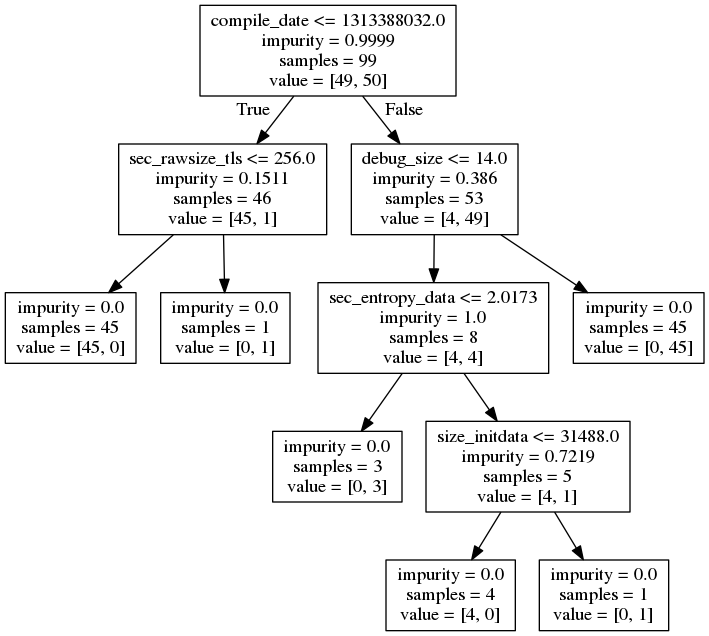

In [6]:
decision_tree = DecisionTreeClassifier(max_depth=10, criterion='entropy')
decision_tree.fit(X,Y)
Decision_Tree_Image(decision_tree, X.columns)

In [7]:
X = X.astype(int)
Y = Y.apply(lambda x: 0 if x == 'bad' else 1)
feature_list = []
info_gain = []

for f in feature:
    IG = best_threshold(X[f], Y)
    feature_list.append(f)
    info_gain.append(IG)
    

sort_ig = np.array(sorted( np.array(zip(feature_list, info_gain)), key = lambda z: z[1], reverse = True))
print "These are the ten most impotant features as they give the most information when calculated the info_gain"
print "The 10 most important features are:\n\n", sort_ig[0:10]


These are the ten most impotant features as they give the most information when calculated the info_gain
The 10 most important features are:

[['compile_date' '0.723063143066']
 ['pe_majorlink' '0.529567490914']
 ['debug_size' '0.468444628138']
 ['pe_char' '0.359182462926']
 ['sec_rawsize_reloc' '0.343461592059']
 ['sec_rawptr_reloc' '0.322682264761']
 ['datadir_IMAGE_DIRECTORY_ENTRY_BASERELOC_size' '0.302913470561']
 ['sec_vasize_reloc' '0.302913470561']
 ['datadir_IMAGE_DIRECTORY_ENTRY_IAT_size' '0.272772991752']
 ['check_sum' '0.257608951698']]


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluating the ML Results
from sklearn import metrics

# Dataset Import
import statsmodels.api as sm

/home/etern3l/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/etern3l/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
# Create the LogisticRegression model
logisticReg= LogisticRegression()

# Fit the data
logisticReg.fit(X,Y)

# Check the accuracy
logisticReg.score(X,Y)

0.84848484848484851

In [10]:
X = pd.DataFrame(X, columns=['compile_date','pe_majorlink','debug_size','pe_char','sec_rawsize_reloc','sec_rawptr_reloc','sec_vasize_reloc',
 'datadir_IMAGE_DIRECTORY_ENTRY_BASERELOC_size','datadir_IMAGE_DIRECTORY_ENTRY_IAT_size','check_sum'])

# Fit our data
logisticReg.fit(X,Y)

logisticReg.score(X,Y)



0.71717171717171713